# Binary Classification with XGBoost and Model Calibration

## Overview
In this project, we train an **XGBoost** classifier on an **imbalanced binary classification problem** and perform **calibration** to improve the predicted probabilities. The calibration is done using **Platt scaling** via the `CalibratedClassifierCV` from scikit-learn. We evaluate the model's performance before and after calibration, using various evaluation metrics such as **ROC AUC**, **Precision-Recall AUC (AUC-PR)**, and **accuracy**.

## Steps:
1. **Data Loading and Preprocessing**:
   - Load and split the dataset into **training**, **validation**, and **test** sets.
   - Perform **feature scaling** on the numerical features.

2. **Train XGBoost Model**:
   - Train the **XGBoost** model on the **training set**.
   - Evaluate the model's performance on the **test set** using **accuracy**, **ROC AUC**, and **AUC-PR**.

3. **Model Calibration**:
   - Use **Platt scaling** to calibrate the predicted probabilities on the **validation set**.
   - Evaluate the **calibrated model** on the **test set** using the same evaluation metrics.

4. **Evaluation**:
   - Compare the **uncalibrated** and **calibrated models** on the **test set** using **ROC curves** and **AUC-PR curves**.
   - Plot the **calibration curve** comparing the **uncalibrated vs calibrated** probabilities, showing how calibration improves the model's predicted probabilities.

5. **Conclusion**:
   - Analyze the performance improvement after applying calibration, especially in terms of better-calibrated probabilities that are closer to the actual fraction of positives.

## Key Metrics Used:
- **Accuracy**: Measures the percentage of correct predictions.
- **ROC AUC**: Measures how well the model distinguishes between the classes.
- **Precision-Recall AUC**: Particularly useful for imbalanced datasets, showing the trade-off between precision and recall.
- **Calibration Curve**: Visualizes the relationship between predicted probabilities and actual positive fractions.

## Calibration and Model Performance:
- The calibration improves the probability predictions, making them more reliable, especially when the model is overestimating or underestimating probabilities.
- The calibration curve shows a noticeable improvement in the calibration after applying Platt scaling, with the calibrated probabilities being much closer to the **perfect calibration** line.

## Libraries Used:
- **XGBoost** for training the classifier.
- **scikit-learn** for model evaluation, calibration, and plotting.
- **matplotlib** for visualization.

## Final Thoughts:
- Calibration is an important step when dealing with imbalanced datasets as it helps produce better probability estimates for decision-making.
- The **AUC-PR curve** and **calibration plot** provide a better understanding of how the model behaves on the minority class after calibration.


In [66]:
#pip install scikit-learn xgboost matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
import xgboost as xgb
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

In [20]:
# Load the Adult Income dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
    'hours-per-week', 'native-country', 'income'
]
data = pd.read_csv(url, names=column_names, sep=",\s*", engine="python")

# Check for missing values and handle them
print(f"Missing values before preprocessing: \n{data.isnull().sum()}\n")
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Encoding categorical features
categorical_cols = data_imputed.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data_imputed[col] = le.fit_transform(data_imputed[col])
    label_encoders[col] = le

Missing values before preprocessing: 
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64



In [22]:
# Feature and target separation
X = data_imputed.drop(columns=['income'])
y = data_imputed['income']

# Split the data into train, validation, and test sets (70%, 15%, 15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardize the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Check the class distribution in the splits
print(f"Class distribution in training set: \n{y_train.value_counts()}")
print(f"Class distribution in validation set: \n{y_val.value_counts()}")
print(f"Class distribution in test set: \n{y_test.value_counts()}")

Class distribution in training set: 
income
0    17303
1     5489
Name: count, dtype: int64
Class distribution in validation set: 
income
0    3708
1    1176
Name: count, dtype: int64
Class distribution in test set: 
income
0    3709
1    1176
Name: count, dtype: int64


In [36]:
# Train an XGBoost model with class imbalance handling
scale_pos_weight = len(y_train) / np.sum(y_train == 1)  # Adjust this to handle imbalance
print(f"Training a model with scale_pos_weight of: {scale_pos_weight}")
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='aucpr', scale_pos_weight=scale_pos_weight)

# Train the model on the training set
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_test_pred = xgb_model.predict(X_test_scaled)
y_test_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

Training a model with scale_pos_weight of: 4.152304609218437
Test Accuracy: 0.8254
Test ROC AUC: 0.9255


C:\Users\Pouri\anaconda3\envs\llms\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [57]:
# Function to plot ROC and AUC-PR curves for both train and test sets in one plot
def plot_roc_auc_pr_comparison(y_train, y_train_pred_proba, y_test, y_test_pred_proba):
    # ROC Curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison (Train vs Test)')
    plt.legend(loc='lower right')

    # AUC-PR Curve
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred_proba)
    auc_pr_train = average_precision_score(y_train, y_train_pred_proba)
    
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)
    auc_pr_test = average_precision_score(y_test, y_test_pred_proba)

    plt.subplot(1, 2, 2)
    plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Train AUC-PR curve (AUC = {auc_pr_train:.2f})')
    plt.plot(recall_test, precision_test, color='green', lw=2, label=f'Test AUC-PR curve (AUC = {auc_pr_test:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('AUC-PR Curve Comparison (Train vs Test)')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()


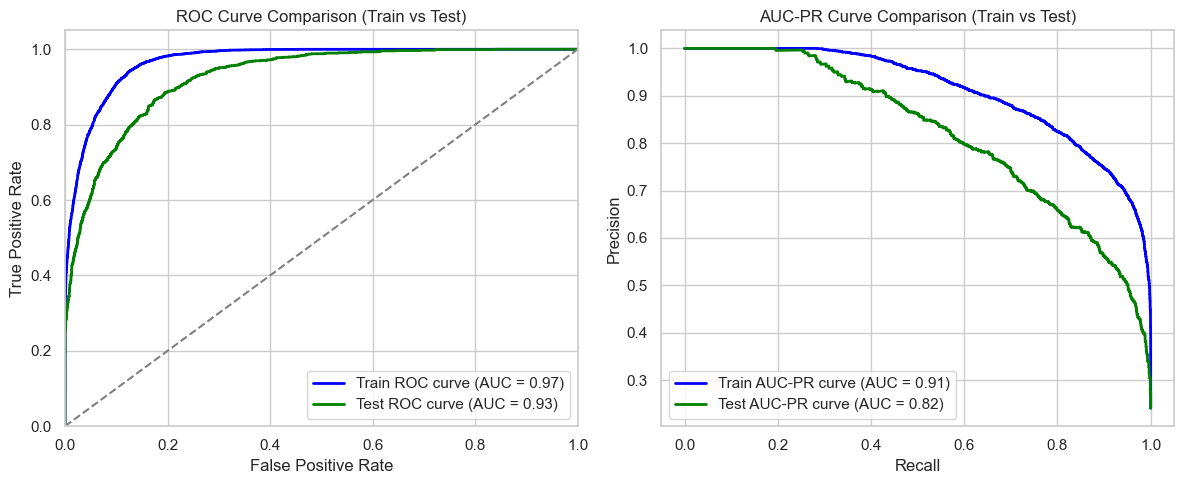

In [58]:
# Predictions for train and test sets
y_train_pred_proba = xgb_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Plot ROC and AUC-PR for both train and test sets in one plot
plot_roc_auc_pr_comparison(y_train, y_train_pred_proba, y_test, y_test_pred_proba)

In [39]:
# Step 1: Calibrate the model using Platt scaling on the validation set
calibrated_xgb = CalibratedClassifierCV(xgb_model, method='sigmoid', cv='prefit')
calibrated_xgb.fit(X_val_scaled, y_val)

# Step 2: Make predictions with the calibrated model on the test set
y_test_pred_calibrated = calibrated_xgb.predict(X_test_scaled)
y_test_pred_proba_calibrated = calibrated_xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluate the calibrated model on the test set
accuracy_calibrated = accuracy_score(y_test, y_test_pred_calibrated)
fpr_calibrated, tpr_calibrated, _ = roc_curve(y_test, y_test_pred_proba_calibrated)
roc_auc_calibrated = auc(fpr_calibrated, tpr_calibrated)

# AUC-PR for calibrated model
precision_calibrated, recall_calibrated, _ = precision_recall_curve(y_test, y_test_pred_proba_calibrated)
auc_pr_calibrated = average_precision_score(y_test, y_test_pred_proba_calibrated)

# Print the results
print(f"Calibrated Model - Test Accuracy: {accuracy_calibrated:.4f}")
print(f"Calibrated Model - Test ROC AUC: {roc_auc_calibrated:.4f}")
print(f"Calibrated Model - Test AUC-PR: {auc_pr_calibrated:.4f}")

Calibrated Model - Test Accuracy: 0.8641
Calibrated Model - Test ROC AUC: 0.9255
Calibrated Model - Test AUC-PR: 0.8212


C:\Users\Pouri\anaconda3\envs\llms\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


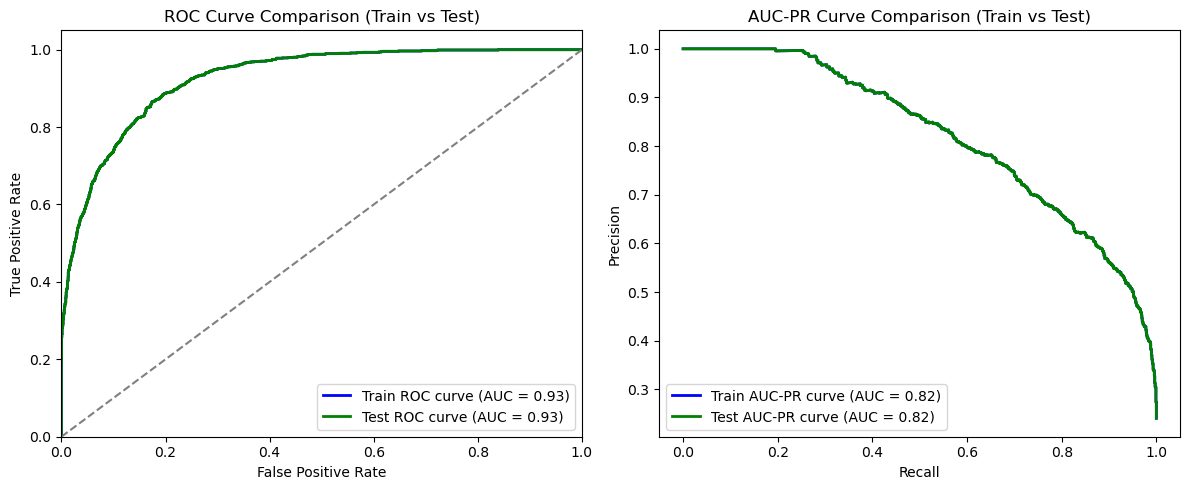

In [40]:

# Plot ROC and AUC-PR curves for calibrated model
plot_roc_auc_pr_comparison(y_test, y_test_pred_proba_calibrated, y_test, y_test_pred_proba_calibrated)

In [64]:
# Function to plot the calibration plot
def plot_calibration_curve(y_true, y_pred_proba_uncalibrated, y_pred_proba_calibrated):
    # Get the calibration curve for uncalibrated and calibrated probabilities
    fraction_of_positives_uncalibrated, mean_predicted_value_uncalibrated = calibration_curve(y_true, y_pred_proba_uncalibrated, n_bins=10)
    fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_true, y_pred_proba_calibrated, n_bins=10)

    # Plot the calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value_uncalibrated, fraction_of_positives_uncalibrated, color='blue', marker='o', label='Uncalibrated Model')
    plt.plot(mean_predicted_value_calibrated, fraction_of_positives_calibrated, color='green', marker='s', label='Calibrated Model')

    # Plot the diagonal (perfectly calibrated) line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfectly calibrated')

    # Formatting the plot
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Plot (Uncalibrated vs Calibrated)')
    plt.legend()
    plt.tight_layout()
    plt.show()

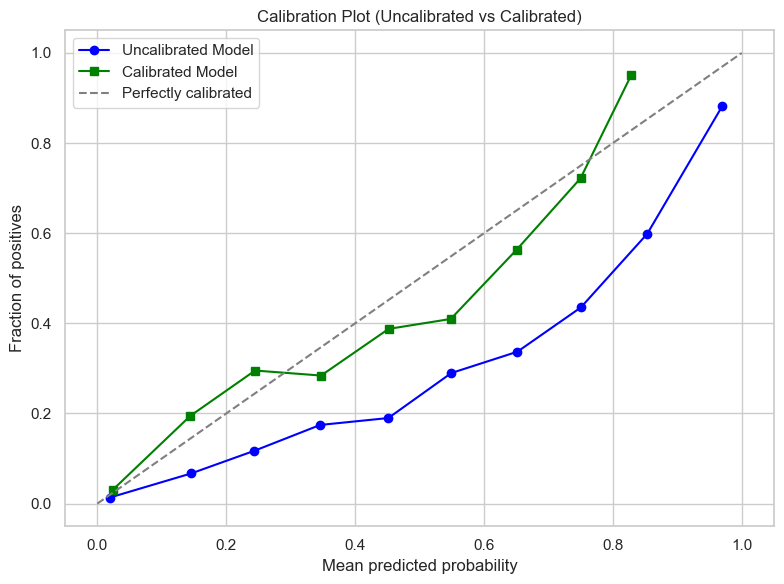

In [65]:
# Get the predicted probabilities for both uncalibrated and calibrated models on the test set
y_test_pred_proba_uncalibrated = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred_proba_calibrated = calibrated_xgb.predict_proba(X_test_scaled)[:, 1]

# Plot the calibration curve for both uncalibrated and calibrated probabilities
plot_calibration_curve(y_test, y_test_pred_proba_uncalibrated, y_test_pred_proba_calibrated)